<a href="https://colab.research.google.com/github/Hoiy/tf_playground/blob/master/bert/BERT_seq_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyarrow

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import numpy as np

In [3]:
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.72.103.58:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2754851474961614753),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9973926884638796039),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1954308813949998616),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2587303164580289331),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1772435157637830472),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12746000272835821318),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 1503042259982952193),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 18095887550285321793),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 147153

In [0]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']  

In [0]:
import tokenization

BERT_PRETRAINED_DIR = 'gs://dev-test-bert-tpu/chinese_bert/'
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
BERT_MODEL = 'chinese_L-12_H-768_A-12'
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

In [6]:
# TASK = 'CoLA' #@param {type:"string"}
# assert TASK in ('MRPC', 'CoLA'), 'Only (MRPC, CoLA) are demonstrated here.'
# Download glue data.
# ! test -d download_glue_repo || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue_repo
# !python download_glue_repo/download_glue_data.py --data_dir='glue_data' --tasks=$TASK
TASK = 'seq_prediction'
!mkdir -p ./dataset
!gsutil rsync gs://kaggle-195702-dataset/hk01 ./dataset

# !wget https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip
# !unzip -o chinese_L-12_H-768_A-12.zip
  
TASK_DATA_DIR = 'dataset'
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model

# BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL
# BERT_PRETRAINED_DIR = '/content/' + BERT_MODEL
BERT_PRETRAINED_DIR = 'gs://dev-test-bert-tpu/chinese_bert/'

print('***** BERT pretrained directory: {} *****'.format(BERT_PRETRAINED_DIR))
!gsutil ls $BERT_PRETRAINED_DIR

BUCKET = 'dev-test-bert-tpu' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert/models/{}'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

Building synchronization state...
Starting synchronization...
***** Task data directory: dataset *****
article_contents.csv		 article_contents.txt	train_features_128.pkl
article_contents.snappy.parquet  test_features_128.pkl	train_features.pkl
***** BERT pretrained directory: gs://dev-test-bert-tpu/chinese_bert/ *****
gs://dev-test-bert-tpu/chinese_bert/
gs://dev-test-bert-tpu/chinese_bert/bert_config.json
gs://dev-test-bert-tpu/chinese_bert/bert_model.ckpt.data-00000-of-00001
gs://dev-test-bert-tpu/chinese_bert/bert_model.ckpt.index
gs://dev-test-bert-tpu/chinese_bert/bert_model.ckpt.meta
gs://dev-test-bert-tpu/chinese_bert/vocab.txt
***** Model output directory: gs://dev-test-bert-tpu/bert/models/seq_prediction *****


In [0]:
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 use_one_hot_embeddings):
  """Creates a classification model."""
  model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids,
      use_one_hot_embeddings=use_one_hot_embeddings)

  final_hidden = model.get_sequence_output()

  final_hidden_shape = modeling.get_shape_list(final_hidden, expected_rank=3)
  batch_size = final_hidden_shape[0]
  seq_length = final_hidden_shape[1]
  hidden_size = final_hidden_shape[2]
  
  print(batch_size)
  print(seq_length)
  print(hidden_size)

  output_weights = tf.get_variable(
      "cls/squad/output_weights", [1, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "cls/squad/output_bias", [1], initializer=tf.zeros_initializer())

  final_hidden_matrix = tf.reshape(final_hidden,
                                   [batch_size * seq_length, hidden_size])
  
  logits = tf.matmul(final_hidden_matrix, output_weights, transpose_b=True)
  logits = tf.nn.bias_add(logits, output_bias)

  logits = tf.reshape(logits, [batch_size, seq_length, 1])
  logits = tf.transpose(logits, [2, 0, 1])

  unstacked_logits = tf.unstack(logits, axis=0)

  (pred_logits) = (unstacked_logits[0])
  
  print(pred_logits)

  return (pred_logits)
    
    

# def model_fn_builder(bert_config, init_checkpoint, learning_rate,
#                      num_train_steps, num_warmup_steps, use_tpu,
#                      use_one_hot_embeddings):
#   """Returns `model_fn` closure for TPUEstimator."""

#   def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
#     """The `model_fn` for TPUEstimator."""

#     tf.logging.info("*** Features ***")
#     for name in sorted(features.keys()):
#       tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

#     input_ids = features["input_ids"]
#     input_mask = features["input_mask"]
#     segment_ids = features["segment_ids"]    
#     truths = features["truths"]

#     is_training = (mode == tf.estimator.ModeKeys.TRAIN)

#     pred = create_model(
#         bert_config=bert_config,
#         is_training=is_training,
#         input_ids=input_ids,
#         input_mask=input_mask,
#         segment_ids=segment_ids,
#         use_one_hot_embeddings=use_one_hot_embeddings)
  
#     tvars = tf.trainable_variables()

#     initialized_variable_names = {}
#     scaffold_fn = None
#     if init_checkpoint:
#       (assignment_map, initialized_variable_names
#       ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
#       if use_tpu:

#         def tpu_scaffold():
#           tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
#           return tf.train.Scaffold()

#         scaffold_fn = tpu_scaffold
#       else:
#         tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

#     tf.logging.info("**** Trainable Variables ****")
#     for var in tvars:
#       init_string = ""
#       if var.name in initialized_variable_names:
#         init_string = ", *INIT_FROM_CKPT*"
#       tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
#                       init_string)

#     output_spec = None
#     if mode == tf.estimator.ModeKeys.TRAIN:
#       seq_length = modeling.get_shape_list(input_ids)[1]
#       total_loss = tf.reduce_mean(
#           tf.reduce_mean(
#               tf.keras.backend.binary_crossentropy(truths, pred), axis=-1))
      
#       train_op = optimization.create_optimizer(
#           total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
      
#       print(truths)
#       print(pred)
#       print(total_loss)

#       output_spec = tf.contrib.tpu.TPUEstimatorSpec(
#           mode=mode,
#           loss=total_loss,
#           train_op=train_op,
#           scaffold_fn=scaffold_fn    
#       )
    
#     elif mode == tf.estimator.ModeKeys.PREDICT:
#       predictions = {
#           "predictions": pred
#       }
#       output_spec = tf.contrib.tpu.TPUEstimatorSpec(
#           mode=mode, predictions=predictions, scaffold_fn=scaffold_fn,
#           eval_metrics=(tf.metrics.auc, {
#             'labels': truths,
#             'predictions': pred,
#             'weights': input_mask
#           })
# )
#     else:
#       raise ValueError(
#           "Only TRAIN and PREDICT modes are supported: %s" % (mode))

#     return output_spec

#   return model_fn



def model_fn_builder(bert_config, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    truths = features["truths"]
    
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    
    predictions = create_model(
        bert_config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)
  
#     (total_loss, per_example_loss, logits, probabilities) = create_model(
#         bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
#         num_labels, use_one_hot_embeddings)

    tvars = tf.trainable_variables()
    initialized_variable_names = {}
    scaffold_fn = None
    if init_checkpoint:
      (assignment_map, initialized_variable_names
      ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
      if use_tpu:

        def tpu_scaffold():
          tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
          return tf.train.Scaffold()

        scaffold_fn = tpu_scaffold
      else:
        tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

              
    tf.logging.info("**** Trainable Variables ****")
    for var in tvars:
      init_string = ""
      if var.name in initialized_variable_names:
        init_string = ", *INIT_FROM_CKPT*"
      tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
                      init_string)

    input_mask_f = tf.cast(input_mask, tf.float32)
    per_example_loss = tf.reduce_sum(tf.keras.backend.binary_crossentropy(truths, predictions) * input_mask_f, axis=-1) / tf.reduce_sum(input_mask_f, axis=-1)
    total_loss = tf.reduce_mean(per_example_loss)


    total_loss = tf.reduce_mean(
      tf.reduce_mean(
        tf.keras.backend.binary_crossentropy(truths, predictions), axis=-1))

      
    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      
      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op,
          scaffold_fn=scaffold_fn)
      
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(truths, predictions, masks):
        
        auc = tf.metrics.auc(
            labels=truths, predictions=tf.nn.sigmoid(predictions), weights=masks)
        
        return {
            "auc": auc,
            "binary_crossentropy": total_loss
        }

      eval_metrics = (metric_fn, [truths, predictions, input_mask])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics,
          scaffold_fn=scaffold_fn)
    else:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          predictions={"predictions": predictions},
          scaffold_fn=scaffold_fn)
    return output_spec

  return model_fn




class DataProcessor(object):
  """Base class for data converters for sequence classification data sets."""

  def get_train_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the train set."""
    raise NotImplementedError()

  def get_dev_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the dev set."""
    raise NotImplementedError()

  def get_test_examples(self, data_dir):
    """Gets a collection of `InputExample`s for prediction."""
    raise NotImplementedError()

  def get_labels(self):
    """Gets the list of labels for this data set."""
    raise NotImplementedError()

  @classmethod
  def _read_tsv(cls, input_file, quotechar=None):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
      reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
      lines = []
      for line in reader:
        lines.append(line)
      return lines


class DataSetProcessor(DataProcessor):
  """Processor for the MultiNLI data set (GLUE version)."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev_matched.tsv")),
        "dev_matched")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test_matched.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["contradiction", "entailment", "neutral"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, tokenization.convert_to_unicode(line[0]))
      text_a = tokenization.convert_to_unicode(line[8])
      text_b = tokenization.convert_to_unicode(line[9])
      if set_type == "test":
        label = "contradiction"
      else:
        label = tokenization.convert_to_unicode(line[-1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples



In [0]:
# Setup task specific model and TPU running config.

import modeling
import optimization
# import run_classifier


# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32 #@param {type:"number"}
EVAL_BATCH_SIZE = 8 #@param {type:"number"}
LEARNING_RATE = 2e-5 #@param {type:"number"}
NUM_TRAIN_EPOCHS = 100.0 #@param {type:"number"}
WARMUP_PROPORTION = 0.1 #@param {type:"number"}
MAX_SEQ_LENGTH = 128 #@param {type:"number"}
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000 #@param {type:"number"}
ITERATIONS_PER_LOOP = 1000 #@param {type:"number"}
NUM_TPU_CORES = 8 #@param {type:"number"}


CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')


# processors = {
#   "cola": run_classifier.ColaProcessor,
#   "mnli": run_classifier.MnliProcessor,
#   "mrpc": run_classifier.MrpcProcessor,
# }
# processor = processors[TASK.lower()]()
# label_list = processor.get_labels()


In [0]:
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

In [10]:
!mkdir -p ./dataset
!gsutil rsync gs://dev-test-bert-tpu/dataset ./dataset

import pickle
  
MAX_SEQ_LENGTH = 128 #@param {'type': 'number'}

def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_truths = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_truths.append(feature.truths)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)
    print(num_examples)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, 
                shape=[num_examples, seq_length],
                name='input_ids_tf_constant',
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                name='input_mask_tf_constant',
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                name='segment_ids_tf_constant',
                dtype=tf.int32),
        "truths":
            tf.constant(
                all_truths, 
                shape=[num_examples, seq_length], 
                name='truths_tf_constant',
                dtype=tf.float32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               truths,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.is_real_example = is_real_example
    self.truths = truths
  
with open('./dataset/train_features_128.pkl', 'rb') as f:
  train_features = pickle.load(f)

Building synchronization state...
Starting synchronization...


In [11]:
num_train_steps = int(
    len(train_features) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)

num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

print(num_train_steps)
print(num_warmup_steps)

model_fn = model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=True,
    use_one_hot_embeddings=True)

545825
54582


In [12]:

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=64
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://dev-test-bert-tpu/bert/models/seq_prediction', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.72.103.58:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83bdf99da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': b'grpc://10.72.103.58:8470', '_evaluation_master': b'grpc://10.72.103.58:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_core

In [0]:
# Train the model.
print('***** Started training at {} *****'.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_features)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('***** Finished training at {} *****'.format(datetime.datetime.now()))

***** Started training at 2018-12-21 09:56:30.131608 *****
  Num examples = 174663
  Batch size = 32
INFO:tensorflow:  Num steps = 545821
INFO:tensorflow:Querying Tensorflow master (b'grpc://10.96.191.170:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14398697125759226736)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6639692014189080735)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 396955583472844017)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7678346788829680275)
INFO:tensorflow:*** Available Device: _DeviceA

In [15]:
# Eval the model.
with open('./dataset/test_features_128.pkl', 'rb') as f:
  eval_features = pickle.load(f)
  
print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(eval_features)))
print('  Batch size = {}'.format(EVAL_BATCH_SIZE))
# Eval will be slightly WRONG on the TPU because it will truncate
# the last batch.
# eval_steps = int(len(eval_features) / EVAL_BATCH_SIZE)
eval_input_fn = input_fn_builder(
    features=eval_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=True)
# result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)

test_pred_gen = estimator.predict(input_fn=eval_input_fn)
test_pred = next(test_pred_gen)
# print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
# output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
# with tf.gfile.GFile(output_eval_file, "w") as writer:
#   print("***** Eval results *****")
#   for key in sorted(result.keys()):
#     print('  {} = {}'.format(key, str(result[key])))
#     writer.write("%s = %s\n" % (key, str(result[key])))

***** Started evaluation at 2018-12-22 04:08:45.163693 *****
  Num examples = 43667
  Batch size = 8
INFO:tensorflow:Querying Tensorflow master (b'grpc://10.72.103.58:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2754851474961614753)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9973926884638796039)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1954308813949998616)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2587303164580289331)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0

In [24]:
!wget https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
!unzip simhei.zip

--2018-12-22 04:13:17--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  37.6MB/s    in 0.3s    

2018-12-22 04:13:18 (37.6 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import seaborn as sns

SEQ_LENGTH = 128

def visualize(inp, truth, pred=None, display_rows=5):
  font_files = font_manager.findSystemFonts(fontpaths='/content')
  font_list = font_manager.createFontList(font_files)
  font_manager.fontManager.ttflist.extend(font_list)
  sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

  fig, ax = plt.subplots(figsize=(24 * SEQ_LENGTH // 64,display_rows / 3))
  sns.heatmap(truth[:display_rows], \
    annot=np.array([[c for c in row] for row in inp[:display_rows]]), \
    fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)
  
  if pred is not None:
    fig, ax = plt.subplots(figsize=(24 * SEQ_LENGTH // 64,display_rows / 3))
    sns.heatmap(pred[:display_rows], \
      annot=np.array([[c for c in row] for row in inp[:display_rows]]), \
      fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)

(1, 128) (1, 128) (1, 128)
['[CLS]' '粟' '米' '」' '，' '是' '民' '多' '人' '的' '[UNK]' '[UNK]' '，' '隨' '便'
 '開' '個' '罐' '頭' '，' '加' '兩' '車' '多' '士' '，' '已' '是' '滿' '足' '的' '一' '餐'
 '。' '但' '加' '點' '雞' '述' '或' '魚' '肚' '，' '又' '可' '成' '為' '席' '上' '一' '道'
 '人' '見' '她' '愛' '的' '湯' '羹' '。' '更' '錄' '接' '張' '間' '澄' '、' '馮' '嘉' '雯'
 '剪' '接' '：' '張' '芷' '澄' '毒' '肚' '，' '：' '豐' '條' '膠' '原' '蛋' '白' '，' '對'
 '皮' '膚' '好' '（' '皮' '亦' '中' '的' '蛋' '白' '質' '有' '建' '有' '屬' '膠' '巴' '蛋'
 '白' '）' '，' '加' '入' '湯' '羹' '美' '味' '又' '養' '顏' '及' '女' '士' '最' '愛' '。'
 '對' '法' '簡' '單' '[SEP]']


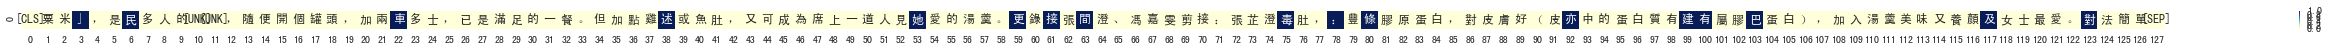

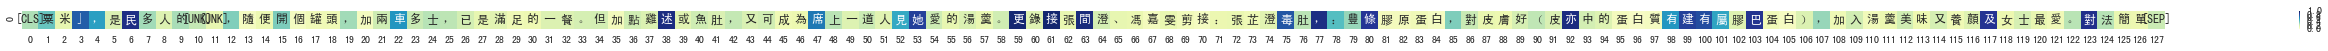

In [44]:
import numpy as np

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

text = np.array([tokenizer.convert_ids_to_tokens(eval_features[0].input_ids)])
pred = np.array([sigmoid(test_pred['predictions'])])
truth = np.array([eval_features[0].truths[:text.shape[-1]]])

print(text.shape, pred.shape, truth.shape)
print(text[0])

visualize(text, truth, pred, 1)

In [48]:
import tensorflow as tf

with tf.Session() as sess:

  truths = tf.constant([[0., 1., 0., 0., 1., 0., 0., 0.], [0., 1., 0., 0., 1., 0., 0., 0.]], dtype=tf.float32)
  predictions = tf.constant([[0.1, 0.8, 0., 0., 0., 0., 0., 0.9], [0.1, 0.8, 0., 0., 0., 0., 0., 0.9]], dtype=tf.float32)
  #   masks = tf.cast(tf.constant([[1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]], dtype=tf.int32), dtype=tf.float32)

  #   per_example_loss = tf.reduce_sum(tf.keras.backend.binary_crossentropy(truths, predictions) * masks, axis=-1) / tf.reduce_sum(masks, axis=-1)

  #   total_loss = tf.reduce_mean(per_example_loss)

  auc, auc_ops = tf.metrics.auc(labels=tf.constant([[0., 1., 0.], [0., 1., 0.]]), predictions=tf.constant([[0., 0.6, 0.7], [0., 0.6, 0.7]]), 
                                weights=tf.constant([[1., 1., 1.], [1., 1., 0.]]))

  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())
  sess.run(auc_ops)
  print(sess.run(auc))
# print(auc.eval())

# sess.close()

0.6666667


In [0]:
-np.log(0.9), -np.log(0.8)